#### Import section

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mplcl
import numpy as np
import glob

#### Plot single disk image

In [20]:
# Code to view planet image

def plot_disk_img(output_dir, field_name, instance,plot_2D=False, polar_contour=False, cartesian = False):

    """
    Plots image of disk density at given instance
    
    """

    parameter_dict = {}
    fargo_par_file = output_dir + "/variables.par"
    # Read the fargo_par_file line by line and store parameters as a dictionary
    with open(fargo_par_file, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue

            words = line.split()
            if len(words) >= 2:
                key = words[0]
                value = words[1]
                parameter_dict[key] = value

    domain_x = np.loadtxt(fname= output_dir + '/domain_x.dat')
    domain_y = np.loadtxt(fname= output_dir + '/domain_y.dat')

    # Remove ghost cells
    domain_y = domain_y[3:-3]

    theta =   0.5*(domain_x[:-1] + domain_x[1:]) #X-Center
    r =   0.5*(domain_y[:-1] + domain_y[1:]) #Y-Center
    # Create meshgrid
    theta, r = np.meshgrid(theta, r)    

    filename = output_dir + '/' + field_name + str(instance) + ".dat"
    data = np.log10(np.fromfile(file = filename).reshape((int(parameter_dict["NY"]), 
                                                          int(parameter_dict["NX"]))))

    norm = mplcl.Normalize(vmin = np.min(data), vmax = np.max(data),
                                    clip = False)
    # method 1
    plot_2D = False
    if plot_2D == True:

        fig, axs = plt.subplots()
        axs.contourf(theta, r, data,100, norm=norm, alpha=1, cmap='YlOrBr')  
            # cbar = plt.colorbar(fig,orientation = "vertical", fraction=0.046, pad=0.04,ax=ax)

        axs.set_xlabel('theta')
        axs.set_ylabel('r')
        plt.show()
        plt.close()

    # method 2
    polar_contour = False
    if polar_contour==True:

        fig, axs = plt.subplots(subplot_kw=dict(projection='polar'))
        axs.contourf(theta, r, data,100, norm=norm, alpha=1, cmap='YlOrBr')  
        # cbar = plt.colorbar(fig,orientation = "vertical", fraction=0.046, pad=0.04,ax=ax)

        axs.set_xlabel('theta')
        axs.set_ylabel('r')

        plt.show()
        plt.close()

    # method 3
    cartesian = True
    if cartesian:

        x_m = r * np.cos(theta)
        y_m = r* np.sin(theta)

        fig, axs = plt.subplots()
        print(np.shape(x_m))
        m = axs.pcolormesh(x_m, y_m, data, cmap="plasma", vmin = np.min(data), vmax = np.max(data))  
        

        fig.colorbar(m) #,orientation = "vertical", fraction=0.046, pad=0.04,ax=axs
        axs.axis('equal')
        axs.axis('square')

        outfile_name = filename.split(".")[0]+'_cartezian.png'  
        print(outfile_name)
        plt.show()
        fig.savefig(fname=outfile_name, dpi=300)
        plt.close()

    return

(128, 384)
/home/mihir/FARGO3d/public/outputs/fargo_1_dust_multi_planet_5/dust1dens50_cartezian.png


/tmp/ipykernel_30445/3216932618.py:72: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m = axs.pcolormesh(x_m, y_m, data, cmap="plasma", vmin = np.min(data), vmax = np.max(data))


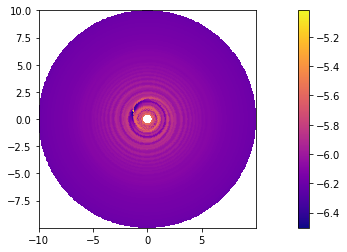

In [22]:
plot_disk_img(output_dir="/home/mihir/FARGO3d/public/outputs/fargo_1_dust_multi_planet_5",
              field_name="dust1dens",instance=50,cartesian=True)

#### Function to plot planet's trajectary

In [4]:
def plot_planet_trajectary(output_dir='outputs/fargo_multifluid',field='dens',fluid='dust',
                           fluid_id='1',trajectary_instance_range=[0,1],
                           plot_instace = '1', planet_id='0', log_dens=True):
    
    """
    Plots trajectary of the planet between instance range on given instance.
    Uses `bigplanet.dat` file in fargo3d output. 
    If plot_instance = [m,n] --> trajectary starts from point at which planet starts in instance m
    and ends at point just before planet starts n+1 th instance. 
    The trajectary will be overploted on plot of instance given in plot_instance.

    Parameters
    ----------
    output_dir      : `string`, Path of fargo3d outputs --- for e.g. fargo3d/public/outputs/fargo_multifluid
    field           : `string`, Name of the field, ("dens", "vx","vy" etc.)
    fluid           : `string`, Name of the fluid, ('"gas", "dust")
    fluid_id        : `string`, Fluid id (0, 1, 2, ...), if fluid is "gas" then fluid_id = ""
    plot_instances  : `list`, list of output instances (integers)  which will needs to be 
                       ploted. Number of elements in the list need to be consistant with
                       grid_dimentions.. i.e. grid_dimensions[0]*grid_dimensions[1] = len(plot_instance)
    grid_dimensions : `list`, number of `rows' and `columns` in the plotting grid (rows need to be 
                      greater then 1), in this order
    planets         : `boolean`, plots position of planets (planet 0 and 1)

    
    
    """
    
    

    # Get values of important variables like Nx, Ny etc.
    variable_file = output_dir+"/variables.par"
    with open(file=variable_file) as f:
        variables = {line.split()[0] : line.split()[1] for line in open(file=variable_file)}
    N_r = int(variables["NX"])
    N_theta = int(variables["NY"])

    # Get coordinates of cells
    domain_x = np.loadtxt(fname= output_dir + '/domain_x.dat')
    domain_y = np.loadtxt(fname= output_dir + '/domain_y.dat')
    # Remove ghost cells from y domain
    domain_y = domain_y[3:-3]

    # Convert define a meshgrid and convert into spherical coordinates
    theta, r = np.meshgrid(domain_x, domain_y)

    x_m = r * np.cos(theta)
    y_m = r * np.sin(theta)


    # Get disk data
    if fluid_id == None:
        data_file = output_dir+"/"+ fluid + field + plot_instace + ".dat"
    else:
        data_file = output_dir+"/"+ fluid + fluid_id  + field + plot_instace + ".dat"

    if log_dens == True:
        data = np.log10(np.fromfile(file = data_file).reshape(N_theta,N_r))
    else:
        data = np.fromfile(file = data_file).reshape(N_theta,N_r)

    
    # Get coordinates of planets from big planet file
    planet_file = output_dir+'/bigplanet' + planet_id + '.dat'
    output_instances = np.loadtxt(fname=planet_file,usecols=0,dtype=int)
    start_index = np.argwhere(output_instances==trajectary_instance_range[0])[0][0]
    end_index = np.argwhere(output_instances==trajectary_instance_range[1])[-1][0]

    planet_x, planet_y = np.loadtxt(fname=planet_file,usecols=[1,2], \
                                    skiprows=start_index, max_rows= \
                                    (end_index-start_index + 1), unpack=True)

    fig, axs = plt.subplots()
    m = axs.pcolormesh(x_m, y_m, data, cmap="plasma", vmin = np.min(data), 
                       vmax = np.max(data))
    axs.scatter(planet_x, planet_y, marker='o',s=2, c='k')
    fig.colorbar(m,orientation = "vertical", fraction=0.046, pad=0.04,ax=axs)
    axs.axis('equal')
    axs.axis('square')
    title = 'Output instance ' + plot_instace
    fig.suptitle(title, fontsize=12)
    sub_title = "Orbit from: " + str(trajectary_instance_range[0]) + " to: " \
                + str(trajectary_instance_range[-1])
    axs.set_title(sub_title, fontsize=9)


    plt.show()
    fig.savefig("planet_trajectory.png", dpi=300, facecolor='white')
    plt.close()    

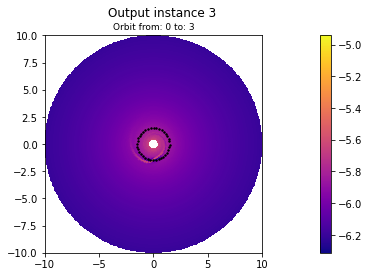

In [11]:
plot_planet_trajectary(output_dir="outputs/fargo_1_dust_multi_planet_5/",fluid='dust',fluid_id='1',
                        trajectary_instance_range=[0,3],plot_instace = '3',
                        planet_id='0', log_dens=True)


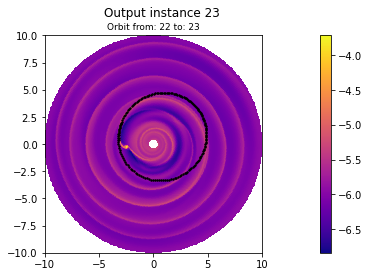

In [19]:
plot_planet_trajectary(output_dir="outputs/fargo_1_dust_multi_planet_992/",fluid='dust',fluid_id='1',
                        trajectary_instance_range=[22,23],plot_instace = '23',
                        planet_id='2', log_dens=True)

In [ ]:
plot_planet_trajectary(output_dir="outputs/fargo_1_dust_multi_planet_5/",fluid='dust',fluid_id='1',
                        trajectary_instance_range=[0,3],plot_instace = '3',
                        planet_id='0', log_dens=True)

#### Function to visualize evolution of protoplanetary disk (grid plots)

In [21]:
def grid_plot(output_dir, field, fluid, fluid_id, plot_instances, grid_dimensions, 
              plot_planets=False, planet_ids=None, log_dens = True):
    """
    Generates 2D grid of plots of protolanetary disks dust density distribution
    generated by FARGO3d.

    Parameters
    ----------
    output_dir      : `string`, Path of fargo3d outputs --- for e.g. fargo3d/public/outputs/fargo_multifluid
    field           : `string`, Name of the field, ("dens", "vx","vy" etc.)
    fluid           : `string`, Name of the fluid, ('"gas", "dust")
    fluid_id        : `string`, Fluid id (0, 1, 2, ...), if fluid is gas then fluid_id = ""
    plot_instances  : `list`, list of output instances (integers)  which will needs to be 
                       ploted. Number of elements in the list need to be consistant with
                       grid_dimentions.. i.e. grid_dimensions[0]*grid_dimensions[1] = len(plot_instance)
    grid_dimensions : `list`, number of `rows' and `columns` in the plotting grid (rows need to be 
                      greater then 1), in this order
    planets         : `boolean`, plots position of planets (planet 0 and 1)
    
    """

    rows = int(grid_dimensions[0])
    cols = int(grid_dimensions[1])

    # Get values of important variables like Nx, Ny etc.
    variable_file = output_dir+"/variables.par"
    with open(file=variable_file) as f:
        variables = {line.split()[0] : line.split()[1] for 
                     line in open(file=variable_file)}
    N_r = int(variables["NX"])
    N_theta = int(variables["NY"])

    domain_x = np.loadtxt(fname= output_dir + '/domain_x.dat') # azimuthual zones
    domain_y = np.loadtxt(fname= output_dir + '/domain_y.dat') # radial zones
    # Remove ghost cells from radial zones
    domain_y = domain_y[3:-3]

    theta, r = np.meshgrid(domain_x, domain_y)
    x = r * np.cos(theta)
    y = r * np.sin(theta)

    if (rows*cols != len(plot_instances)):
        print(" Error: multiplication of dimensions of grid rows and columns \
              do not match length of plot_instances list")
        return
    
    if (planet_ids == None and plot_planets == True):
        print(" Yon need to tell which planets to plot, \n \
               planet_ids can not be none")
        return


    fig, ax = plt.subplots(nrows = rows, ncols = cols, figsize = (12,8),\
                           constrained_layout=True)

    index = 0    
    for i in range(rows):
        
        for j in range(cols):

            filename = output_dir + "/" + fluid + fluid_id + field + \
                        str(plot_instances[index]) + ".dat"
            if log_dens == True:
                data = np.log10(np.fromfile(file = filename).reshape(N_theta, N_r))
            else:
                data = np.fromfile(file = filename).reshape(N_theta, N_r)
            
            ax[i,j].pcolormesh(x, y, data, cmap="plasma", vmin = np.min(data), 
                       vmax = np.max(data))
            
            if plot_planets==True:
                for planet_id in planet_ids:

                    planet_x, planet_y = np.loadtxt(fname= output_dir +'/planet'+ \
                                                        str(planet_id) + '.dat', \
                                                        usecols=(1,2), \
                                                        skiprows=plot_instances[index],\
                                                        max_rows=1,
                                                        unpack=True)

                    ax[i,j].scatter(planet_x, planet_y, marker='X',c = 'k')

            ax[i,j].axis('equal')
            ax[i,j].axis('square')
            xlabel, ylabel = "x", "y"
            title = 'Output_instance ' + str(plot_instances[index])
            ax[i,j].set_title(title, fontsize = 12)
            ax[i,j].set_xlabel(xlabel,fontsize=12)
            ax[i,j].set_ylabel(ylabel,fontsize=12)

            index = index + 1
            data = []  # clear data

    fig.show()
     
    return

/tmp/ipykernel_206/1557047692.py:93: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


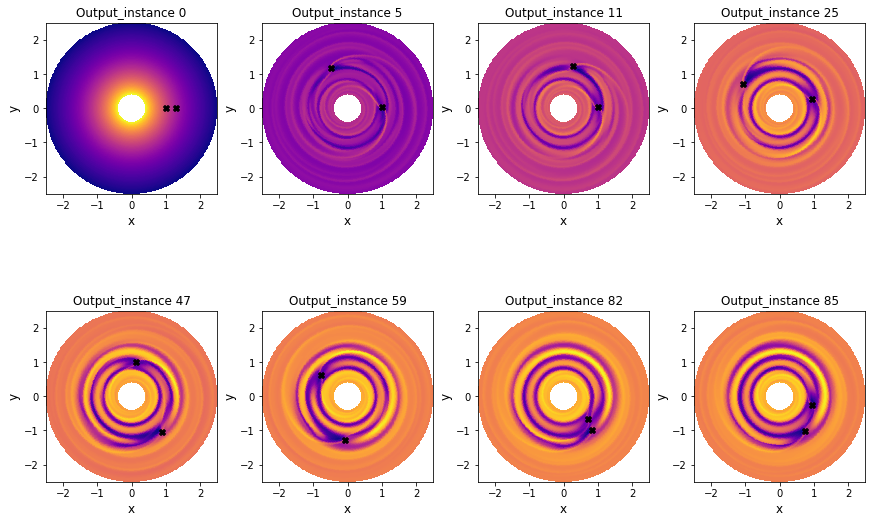

In [35]:
grid_plot(output_dir="outputs_old/fargo_mf_tp_2/", field="dens",
          fluid="dust",fluid_id="1",plot_instances=[0,5,11,25,47,59,82, 85], 
          grid_dimensions=[2,4], plot_planets=True, planet_ids=[0,2])

/tmp/ipykernel_23738/2560577108.py:93: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


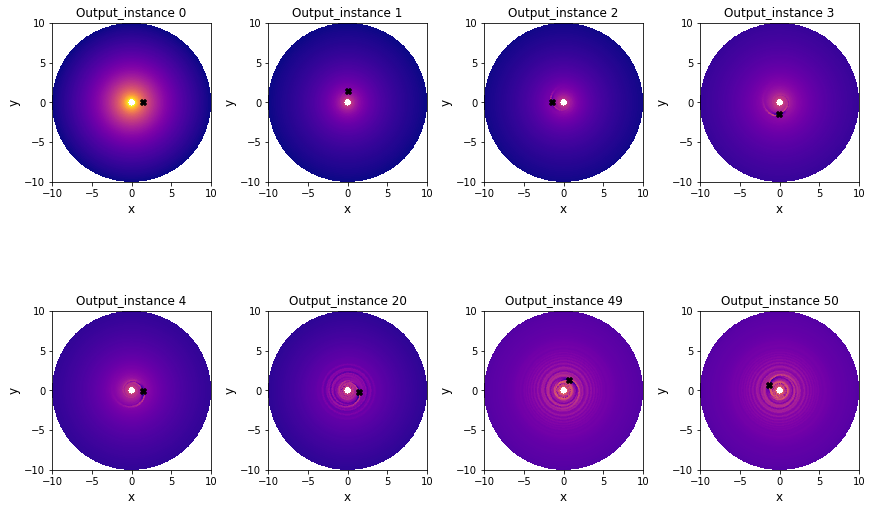

In [8]:

grid_plot(field = "dens", fluid="gas", fluid_id="", output_dir='outputs/fargo_1_dust_multi_planet_5', 
          plot_instances = [0,1,2,3,4,20,49,50], 
          grid_dimensions = [2,4], plot_planets=True, planet_ids=[0])

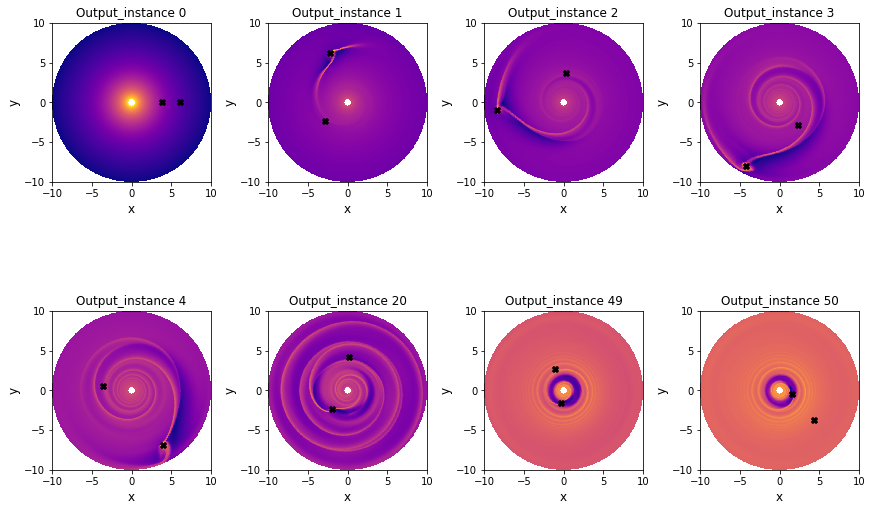

In [23]:

grid_plot(field = "dens", fluid="gas", fluid_id="", output_dir='outputs/fargo_1_dust_multi_planet_992', 
          plot_instances = [0,1,2,3,4,20,49,50], 
          grid_dimensions = [2,4], plot_planets=True, planet_ids=[0,2])

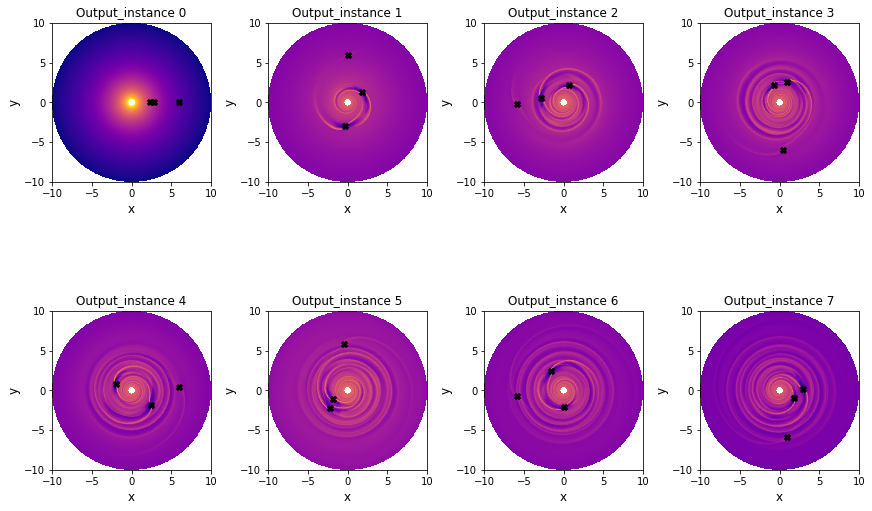

In [25]:
grid_plot(field = "dens", fluid="gas", fluid_id="", output_dir='outputs/fargo_1_dust_multi_planet_11', 
          plot_instances = [0,1,2,3,4,5,6,7], 
          grid_dimensions = [2,4], plot_planets=True, planet_ids=[0,1,2])